In [1]:
import json
import csv

import sys
sys.path.append("../../")
#sys.path.append("/home/rosa/DefmodEnv/lib/python3.7/site-packages/")

import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import math
import pickle

import implicitmodules.torch as dm
from implicitmodules.torch.HamiltonianDynamic import Hamiltonian, shoot
from implicitmodules.torch.MultiShape import MultiShapeHamiltonian

torch.set_default_tensor_type(torch.DoubleTensor)
dtype = torch.float64

In [2]:
pwd

'/home/gris/projects_py3/implicitmodules3/script/torch'

In [3]:
path_image = '../../../../Data/2DShapes/ShapesJSON/Shapes/'

with open(path_image + 'ray-3.json') as f:
        subj_dict = json.load(f)
        Npts = len(subj_dict['points'])
        subj = []
        for i in range(Npts-1):
            subj.append([subj_dict['points'][i]['x'], subj_dict['points'][i]['y']])

        source = np.array(subj)
        
with open(path_image + 'ray-4.json') as f:
        subj_dict = json.load(f)
        Npts = len(subj_dict['points'])
        subj = []
        for i in range(Npts-1):
            subj.append([subj_dict['points'][i]['x'], subj_dict['points'][i]['y']])

        target = np.array(subj)

In [4]:
#for i in range(5):
#    with open(path_image + 'ray-' + str(i+1) + '.json') as f:
#        subj_dict = json.load(f)
#        Npts = len(subj_dict['points'])
#        subj = []
#        for i in range(Npts-1):
#            subj.append([subj_dict['points'][i]['x'], subj_dict['points'][i]['y']])

#        subject = np.array(subj)
        
#        plt.figure()
#        plt.plot(subject[:,0], subject[:,1])
#        plt.show()

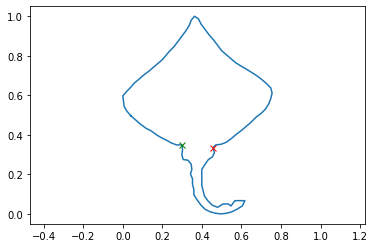

In [5]:
i = 54
j = 95
plt.figure()
plt.plot(source[:,0], source[:,1])
plt.plot(source[i,0], source[i,1], 'xr')
plt.plot(source[j,0], source[j,1], 'xg')
plt.axis('equal')
plt.show()

source = torch.tensor(source)
source0 = torch.cat([source[:i+1,:],source[j:-1,:]])
source1 = source[i:j+1,:]

N = 10
a = source[i,:]
b = source[j,:]
X = torch.linspace(0, 1, N)
boundary_pts = a + torch.mul((b-a).view(-1,2) ,torch.mul(X.view(10,1), torch.ones(1,2)))


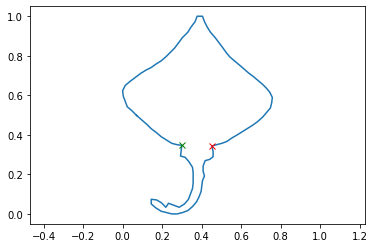

In [6]:
i = 55
j = 96
plt.figure()
plt.plot(target[:,0], target[:,1])
plt.plot(target[i,0], target[i,1], 'xr')
plt.plot(target[j,0], target[j,1], 'xg')
plt.axis('equal')

plt.show()

target = torch.tensor(target)
target0 = torch.cat([target[:i+1,:],target[j:,:]])
target1 = target[i:j+1,:]

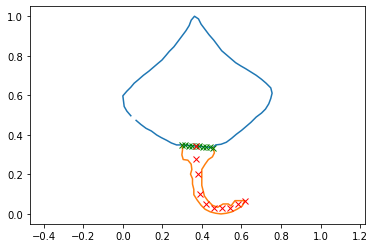

In [7]:
translations_pts = torch.tensor([[0.38, 0.2], [0.37, 0.28], [0.39, 0.1], [0.42, 0.05], [0.46, 0.03], [0.5, 0.03], [0.54, 0.03], [0.58, 0.05],])
translations_pts = torch.cat([boundary_pts[5,:].view(1,2), translations_pts, source1[19,:].view(1,2)])



plt.figure()
plt.plot(source0[:,0], source0[:,1])
plt.plot(source1[:,0], source1[:,1])
plt.plot(boundary_pts[:,0], boundary_pts[:,1], 'gx')
plt.plot(translations_pts[:,0], translations_pts[:,1], 'rx')
plt.axis('equal')
plt.show()

In [8]:
boundary_pts[0], boundary_pts[1]

(tensor([0.4564, 0.3356]), tensor([0.4389, 0.3371]))

In [9]:
translations_pts

tensor([[0.3688, 0.3430],
        [0.3800, 0.2000],
        [0.3700, 0.2800],
        [0.3900, 0.1000],
        [0.4200, 0.0500],
        [0.4600, 0.0300],
        [0.5000, 0.0300],
        [0.5400, 0.0300],
        [0.5800, 0.0500],
        [0.6175, 0.0671]])

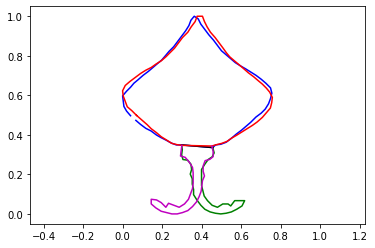

In [10]:
plt.figure()
plt.plot(source0[:,0], source0[:,1], 'b')
plt.plot(source1[:,0], source1[:,1], 'g')
plt.plot(boundary_pts[:,0], boundary_pts[:,1], 'k')

plt.plot(target0[:,0], target0[:,1], 'r')
plt.plot(target1[:,0], target1[:,1], 'm')
plt.axis('equal')
plt.show()

In [11]:
translations_pts.shape, boundary_pts.shape

(torch.Size([10, 2]), torch.Size([10, 2]))

In [22]:
boundary_pts

tensor([[0.4564, 0.3356],
        [0.4389, 0.3371],
        [0.4213, 0.3386],
        [0.4038, 0.3400],
        [0.3863, 0.3415],
        [0.3688, 0.3430],
        [0.3512, 0.3445],
        [0.3337, 0.3460],
        [0.3162, 0.3475],
        [0.2987, 0.3490]], requires_grad=True)

In [29]:
boundary0 = dm.MultiShape.Boundary(boundary_pts)
boundary1 = dm.MultiShape.Boundary(boundary_pts)
NN = 2
#boundary0 = dm.MultiShape.Boundary(source0[::NN,:].contiguous())
#boundary1 = dm.MultiShape.Boundary(source1[::NN,:].contiguous())

source_deformable0 = dm.Models.DeformablePoints(source0)
source_deformable1 = dm.Models.DeformablePoints(source1)
target_deformable0 = dm.Models.DeformablePoints(target0)
target_deformable1 = dm.Models.DeformablePoints(target1)

#define modules
sigma0 = 0.5
translation0 = dm.DeformationModules.Translations(2, 1, sigma0, gd=torch.tensor([[0.39, 0.6]], requires_grad=True))
translation0.to_(dtype)

sigma1 = 0.05
translations_pts.requires_grad = True
translation1 = dm.DeformationModules.Translations(2,translations_pts.shape[0], sigma1, gd = translations_pts)
translation1.to_(dtype)
# add small translations on the boundary
boundary_pts.requires_grad = True
translations_boundary = dm.DeformationModules.Translations(2, 5, 0.015, gd = boundary_pts[::2,:])

silent_boundary0 = dm.DeformationModules.SilentLandmarks(2, boundary_pts.shape[0], boundary_pts)
silent_boundary1 = dm.DeformationModules.SilentLandmarks(2, boundary_pts.shape[0], boundary_pts)

In [30]:
compound_man = dm.MultiShape.MultishapeCompoundManifold.MultishapeCompoundManifold(
    [dm.Manifolds.CompoundManifold([source_deformable0.silent_module.manifold.clone(requires_grad=True),translation0.manifold.clone(requires_grad=True), boundary0.silent_module.manifold.clone(requires_grad=True)]), 
     dm.Manifolds.CompoundManifold([source_deformable1.silent_module.manifold.clone(requires_grad=True), translation1.manifold.clone(requires_grad=True), translations_boundary.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)])])


sigmas_varifold = [1., 0.5]
attach = dm.Attachment.VarifoldAttachment(2, sigmas_varifold)

In [31]:
shoot_solver = 'torch_euler'
shoot_it = 10

constraints_shared = dm.Constraints.Constraints.ConstraintsPointIdentityBase([0,2], [1, 3],compound_man)
#constraints_bg0 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(0, compound_man)
#constraints_bg1 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(1, compound_man)

#constraints = dm.Constraints.Constraints.CompoundConstraints([constraints_bg0, constraints_bg1])#, constraints_shared])
constraints = constraints_shared
sigma_bck = 0.1
model = dm.Models.RegistrationModelMultishape([boundary0, boundary1], [source_deformable0, source_deformable1], [[translation0], [translation1,  translations_boundary]], [attach, attach], sigma_bck, lam=300., constraints=constraints, backgroundtype=None)
multishape = dm.MultiShape.MultiShape.MultiShapeModules(model.modules, sigma_bck)

In [32]:
fitter = dm.Models.Fitter(model)
shoot_solver = 'torch_euler'
costs = fitter.fit([target_deformable0, target_deformable1], 40, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it})

Starting optimization with method Scipy L-BFGS-B
Initial cost={'deformation': 0.0, 'attach': 27.458186382528837}
Time: 8.720668351998029
Iteration: 0
Costs
deformation=0.0014617701656442993
attach=20.78077439930066
Total cost=20.782236169466305
Time: 10.16131517499889
Iteration: 1
Costs
deformation=0.0007046509286710427
attach=15.997921914029867
Total cost=15.998626564958538
Time: 12.92731061700033
Iteration: 2
Costs
deformation=0.002409975687925916
attach=14.253508065178245
Total cost=14.25591804086617
Time: 14.364062837001256
Iteration: 3
Costs
deformation=0.0019574421461500025
attach=13.121448055569406
Total cost=13.123405497715556
Time: 17.73861813699841
Iteration: 4
Costs
deformation=0.0018586012321057841
attach=12.955882026007103
Total cost=12.95774062723921
Time: 50.63304166200032
Iteration: 5
Costs
deformation=0.0018586012321057841
attach=12.955882026007103
Total cost=12.95774062723921
Optimisation process exited with message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [33]:
out = model.compute_deformed(shoot_solver, shoot_it)

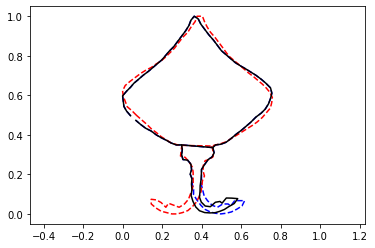

In [34]:
shape0_defo = out[0][0]
shape1_defo = out[1][0]

source = [source0, source1]
target = [target0, target1]

plt.plot(source[0][:,0].detach(), source[0][:,1].detach(), '--b')
plt.plot(source[1][:,0].detach(), source[1][:,1].detach(), '--b')
plt.plot(target[0][:,0].detach(), target[0][:,1].detach(), '--r')
plt.plot(target[1][:,0].detach(), target[1][:,1].detach(), '--r')
plt.plot(shape0_defo[:,0].detach(), shape0_defo[:,1].detach(), '-k')
plt.plot(shape1_defo[:,0].detach(), shape1_defo[:,1].detach(), '-k')
plt.axis('equal')
plt.show()

In [17]:
fac = 50
grid_resolution = [fac, fac]
gridmod = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(torch.cat([source[0], source[1]])).scale([1.5,1.]), grid_resolution)

In [18]:
grid = gridmod.togrid()

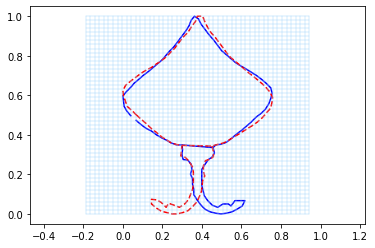

In [19]:

ax = plt.subplot()
plt.plot(source[0][:,0].detach(), source[0][:,1].detach(), '-b')
plt.plot(source[1][:,0].detach(), source[1][:,1].detach(), '-b')
plt.plot(target[0][:,0].detach(), target[0][:,1].detach(), '--r')
plt.plot(target[1][:,0].detach(), target[1][:,1].detach(), '--r')

dm.Utilities.plot_grid(ax, grid[0], grid[1], color='xkcd:light blue', lw=0.4)
plt.axis('equal')
plt.show()

In [51]:

boundary0 = dm.MultiShape.Boundary(copy.copy(source[0][::NN]))
boundary1 = dm.MultiShape.Boundary(copy.copy(source[1][::NN]))

ind_grid_0 = torch.where(boundary0.isin_label(gridmod.manifold.gd)==True)
ind_grid_1 = torch.where(boundary1.isin_label(gridmod.manifold.gd)==True)
ind_grid_bck = torch.where((boundary0.isin_label(gridmod.manifold.gd)==False)*(boundary1.isin_label(gridmod.manifold.gd)==False)==True)

In [52]:
pts_0 = gridmod.manifold.gd[ind_grid_0].clone().contiguous()
pts_1 = gridmod.manifold.gd[ind_grid_1].clone().contiguous()
pts_bck = gridmod.manifold.gd[ind_grid_bck].clone().contiguous()

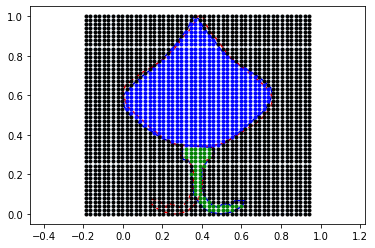

In [53]:

ax = plt.subplot()
plt.plot(source[0][:,0].detach(), source[0][:,1].detach(), '-b')
plt.plot(source[1][:,0].detach(), source[1][:,1].detach(), '-b')
plt.plot(target[0][:,0].detach(), target[0][:,1].detach(), '--r')
plt.plot(target[1][:,0].detach(), target[1][:,1].detach(), '--r')

dm.Utilities.plot_grid(ax, grid[0], grid[1], color='xkcd:light blue', lw=0.4)
plt.plot(pts_0[:,0].detach(), pts_0[:,1].detach(), '.b')
plt.plot(pts_1[:,0].detach(), pts_1[:,1].detach(), '.g')
plt.plot(pts_bck[:,0].detach(), pts_bck[:,1].detach(), '.k')

plt.axis('equal')
plt.show()

In [54]:
module_list = model.modules

for i, mod in enumerate(module_list):
    mod.manifold.fill_gd(model.init_manifold[i].gd)
    mod.manifold.fill_cotan(model.init_manifold[i].cotan)
    
grid0_deformable = dm.Models.DeformablePoints(pts_0)
grid1_deformable = dm.Models.DeformablePoints(pts_1)
gridbck_deformable = dm.Models.DeformablePoints(pts_bck)
grids_deformable = [grid0_deformable, grid1_deformable, gridbck_deformable]

In [79]:
module_list_grid = []
for mod, defgrid in zip(module_list[:-1], grids_deformable[:-1]):
    module_list_grid.append(dm.DeformationModules.CompoundModule([mod[0], defgrid.silent_module, *mod[1:]]))
module_list_grid.append(dm.DeformationModules.CompoundModule([*module_list[-1], grids_deformable[-1].silent_module]))

In [56]:

compound_man_grid = dm.MultiShape.MultishapeCompoundManifold.MultishapeCompoundManifold(
    [dm.Manifolds.CompoundManifold([source_deformable0.silent_module.manifold.clone(requires_grad=True),translation0.manifold.clone(requires_grad=True), boundary.silent_module.manifold.clone(requires_grad=True), boundary0.silent_module.manifold.clone(requires_grad=True)]), 
     dm.Manifolds.CompoundManifold([source_deformable1.silent_module.manifold.clone(requires_grad=True), translation1.manifold.clone(requires_grad=True), translations_boundary.manifold.clone(requires_grad=True), boundary.silent_module.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)]),
     dm.Manifolds.CompoundManifold([boundary0.silent_module.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)])])

sigma_bck = 0.1

constraints_grid_shared = dm.Constraints.Constraints.ConstraintsPointIdentityBase([0,2], [1, 3],compound_man)
constraints_grid_bg0 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(0, compound_man)
constraints_grid_bg1 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(1, compound_man)

constraints_grid = dm.Constraints.Constraints.CompoundConstraints([constraints_grid_bg0, constraints_grid_bg1])#, constraints_shared])


In [57]:
multishape_grid = dm.MultiShape.MultiShape.MultiShapeModules(module_list_grid, sigma_bck)
Ham_grid = MultiShapeHamiltonian.Hamiltonian_multishape(multishape_grid, constraints_grid)

In [58]:
[multishape.manifold.gd[0][i].shape for i in range(4)] ,[multishape.manifold.gd[1][i].shape for i in range(5)] ,[multishape.manifold.gd[2][i].shape for i in range(2)] 

([torch.Size([65, 2]),
  torch.Size([1, 2]),
  torch.Size([10, 2]),
  torch.Size([33, 2])],
 [torch.Size([42, 2]),
  torch.Size([10, 2]),
  torch.Size([5, 2]),
  torch.Size([10, 2]),
  torch.Size([21, 2])],
 [torch.Size([33, 2]), torch.Size([21, 2])])

In [59]:
[multishape_grid.manifold.gd[0][i].shape for i in range(5)] ,[multishape_grid.manifold.gd[1][i].shape for i in range(6)] ,[multishape_grid.manifold.gd[2][i].shape for i in range(3)] 

([torch.Size([65, 2]),
  torch.Size([600, 2]),
  torch.Size([1, 2]),
  torch.Size([10, 2]),
  torch.Size([33, 2])],
 [torch.Size([42, 2]),
  torch.Size([60, 2]),
  torch.Size([10, 2]),
  torch.Size([5, 2]),
  torch.Size([10, 2]),
  torch.Size([21, 2])],
 [torch.Size([33, 2]), torch.Size([21, 2]), torch.Size([1840, 2])])

In [60]:
shoot(Ham_grid, shoot_solver, shoot_it)
shape0_defo_grid = Ham_grid.module.modules[0][0].manifold.gd
shape1_defo_grid = Ham_grid.module.modules[1][0].manifold.gd

RuntimeError: The size of tensor a (10) must match the size of tensor b (33) at non-singleton dimension 0

In [ ]:
grid0_deformed_pts = Ham_grid.module.modules[0][1].manifold.gd
grid1_deformed_pts = Ham_grid.module.modules[1][1].manifold.gd
gridbck_deformed_pts = Ham_grid.module.modules[2][-1].manifold.gd

In [ ]:
gridmod.manifold.gd[ind_grid_0] = grid0_deformed_pts.clone()
gridmod.manifold.gd[ind_grid_1] = grid1_deformed_pts.clone()
gridmod.manifold.gd[ind_grid_bck] = gridbck_deformed_pts.clone()
grid_deformed = gridmod.togrid()

NameError: name 'shape0_defo_grid' is not defined

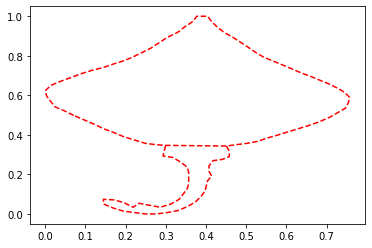

In [49]:

ax = plt.subplot()
#plt.plot(source[0][:,0].detach(), source[0][:,1].detach(), '-b')
#plt.plot(source[1][:,0].detach(), source[1][:,1].detach(), '-b')
plt.plot(target[0][:,0].detach(), target[0][:,1].detach(), '--r')
plt.plot(target[1][:,0].detach(), target[1][:,1].detach(), '--r')
plt.plot(shape0_defo_grid[:,0].detach(), shape0_defo[:,1].detach(), '-k')
plt.plot(shape1_defo_grid[:,0].detach(), shape1_defo[:,1].detach(), '-k')

#dm.Utilities.plot_grid(ax, grid_deformed[0], grid_deformed[1], color='xkcd:light blue', lw=0.4)
plt.axis('equal')
plt.show()